created by Corinne Orton 4-12-25.
Run different evaluations, using code defined in "understanding how dr tools work..."

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
from evaluation import *
# might need to import run_script from this link?? found it in github comments
# https://github.com/mamba-org/mamba/blob/main/libmamba/src/core/link.cpp#L314

## load data ##

### CAFs ###

In [3]:
path = '/Users/corinne/Documents/GitHub/drpaper25/'
expr = pd.read_csv(path + 'data/CAFs.txt', sep='\t')
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/corinne/Documents/GitHub/drpaper25/data/CAFs.txt'

#### Kang #### 
Downloaded from https://github.com/hyhuang00/scRNA-DR2020/tree/main/data on 7-21-25.<br>


In [4]:
path = '/Users/corinne/Documents/GitHub/drpaper25/'
X_train = np.load("data/"+ "kang_log_pca.npy")
y_train = np.load("data/"+ "kang_labels.npy")

In [15]:
import os
cwd = os.getcwd()

In [38]:
algorithms = ['pca', 'tsne', 'umap', 'pacmap']
datasets = ['CAFs', 'Muraro']

filepaths = []
results = []
for algorithm in algorithms:
    for dataset in datasets:
        filepath = f'{cwd}/embeddings/{dataset}/{dataset}_{algorithm}.npy'

        if not os.path.exists(filepath):
            continue

        if dataset == 'CAFs':
            expr = pd.read_csv(f'{cwd}/data/CAFs.txt', sep='\t')
            X_train = expr.values[:,0:(expr.shape[1]-1)]
            X_train = np.log(X_train + 1)
            y_train = expr.values[:,expr.shape[1]-1]
        elif dataset == 'Muraro':
            X_train = np.load(f"{cwd}/data/muraro_log_pca.npy")
            y_train = np.load(f"{cwd}/data/muraro_labels.npy")
            
        embedding = np.load(filepath)

        result = dict()
        result['dataset'] = dataset
        result['algorithm'] = algorithm
        rt_acc = np.zeros(5,)
        for i in range(5):
            rt_acc[i] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
        result['rt'] = np.mean(rt_acc)

        centr_acc = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
        result['centr'] = np.mean(centr_acc)

        n_neighbors = [1, 3, 5, 10, 15, 20]
        for n_neighbor in n_neighbors:
            knn = knn_eval(embedding, y_train, n_neighbors = n_neighbor)
            result[f'knn_{n_neighbor}'] = knn

        results.append(result)

df = pd.DataFrame(results)
df

,dataset,algorithm,rt,centr,knn_1,knn_3,knn_5,knn_10,knn_15,knn_20
0,CAFs,pca,0.788827,0.800000,0.886872,0.918994,0.932961,0.935754,0.934358,0.934358
1,Muraro,pca,0.756652,0.796825,0.593777,0.627958,0.655127,0.683173,0.692375,0.695443
2,CAFs,tsne,0.777542,1.000000,0.988827,0.990223,0.990223,0.986034,0.986034,0.986034
3,CAFs,umap,0.780223,0.866667,0.995810,0.997207,0.997207,0.994413,0.990223,0.990223
4,Muraro,umap,0.634706,0.607937,0.948291,0.957493,0.960999,0.958808,0.959246,0.959246
5,CAFs,pacmap,0.793073,0.866667,0.991620,0.990223,0.991620,0.991620,0.991620,0.991620


In [39]:
df.sort_values(by = 'dataset')

,dataset,algorithm,rt,centr,knn_1,knn_3,knn_5,knn_10,knn_15,knn_20
0,CAFs,pca,0.788827,0.800000,0.886872,0.918994,0.932961,0.935754,0.934358,0.934358
2,CAFs,tsne,0.777542,1.000000,0.988827,0.990223,0.990223,0.986034,0.986034,0.986034
3,CAFs,umap,0.780223,0.866667,0.995810,0.997207,0.997207,0.994413,0.990223,0.990223
5,CAFs,pacmap,0.793073,0.866667,0.991620,0.990223,0.991620,0.991620,0.991620,0.991620
1,Muraro,pca,0.756652,0.796825,0.593777,0.627958,0.655127,0.683173,0.692375,0.695443
4,Muraro,umap,0.634706,0.607937,0.948291,0.957493,0.960999,0.958808,0.959246,0.959246


## Load embedding ##

In [10]:
#embedding = np.load("pca_init_plots/cell mix/cell980_umap.npy")
embedding = np.load("./embeddings/CAFs/CAFs_pacmap.npy")
print(embedding.shape)

(716, 2)


## Random Triplet Accuracy ##

In [20]:
rt_acc = np.zeros(5,)
for i in range(5):
    rt_acc[i] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
# round to 4 decimals
print (f"{np.mean(rt_acc):.4f}", "&", f"{np.std(rt_acc):.4f}") # latex format

0.7881 & 0.0095


## Centroid Triplet Accuracy ##

In [22]:
centr_acc = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
print (f"{centr_acc:.4f}")

0.8667


## kNN ##

In [23]:
knn_arr = knn_eval_series(embedding, y_train, n_neighbors_list=[1,3,5,10,15,20])
print(" & ".join(map(str, np.around(knn_arr,4))))

0.9916 & 0.9902 & 0.9916 & 0.9916 & 0.9916 & 0.9916


## overall structure ##

In [24]:
# use centroid triplet instead - Corinne 4-21
overall = (np.array(knn_arr) + centr_acc)/2
print(" & ".join(map(str, np.around(overall,4))), "&", "\\textbf{"+f"{np.mean(overall):.4f}"+"}")

0.9291 & 0.9284 & 0.9291 & 0.9291 & 0.9291 & 0.9291 & \textbf{0.9290}


## Plot ##

In [8]:
# load an embedding
embedding = np.load("/Users/corinne/Documents/GitHub/drpaper25/embeddings/Kang/Kang_umap.npy")

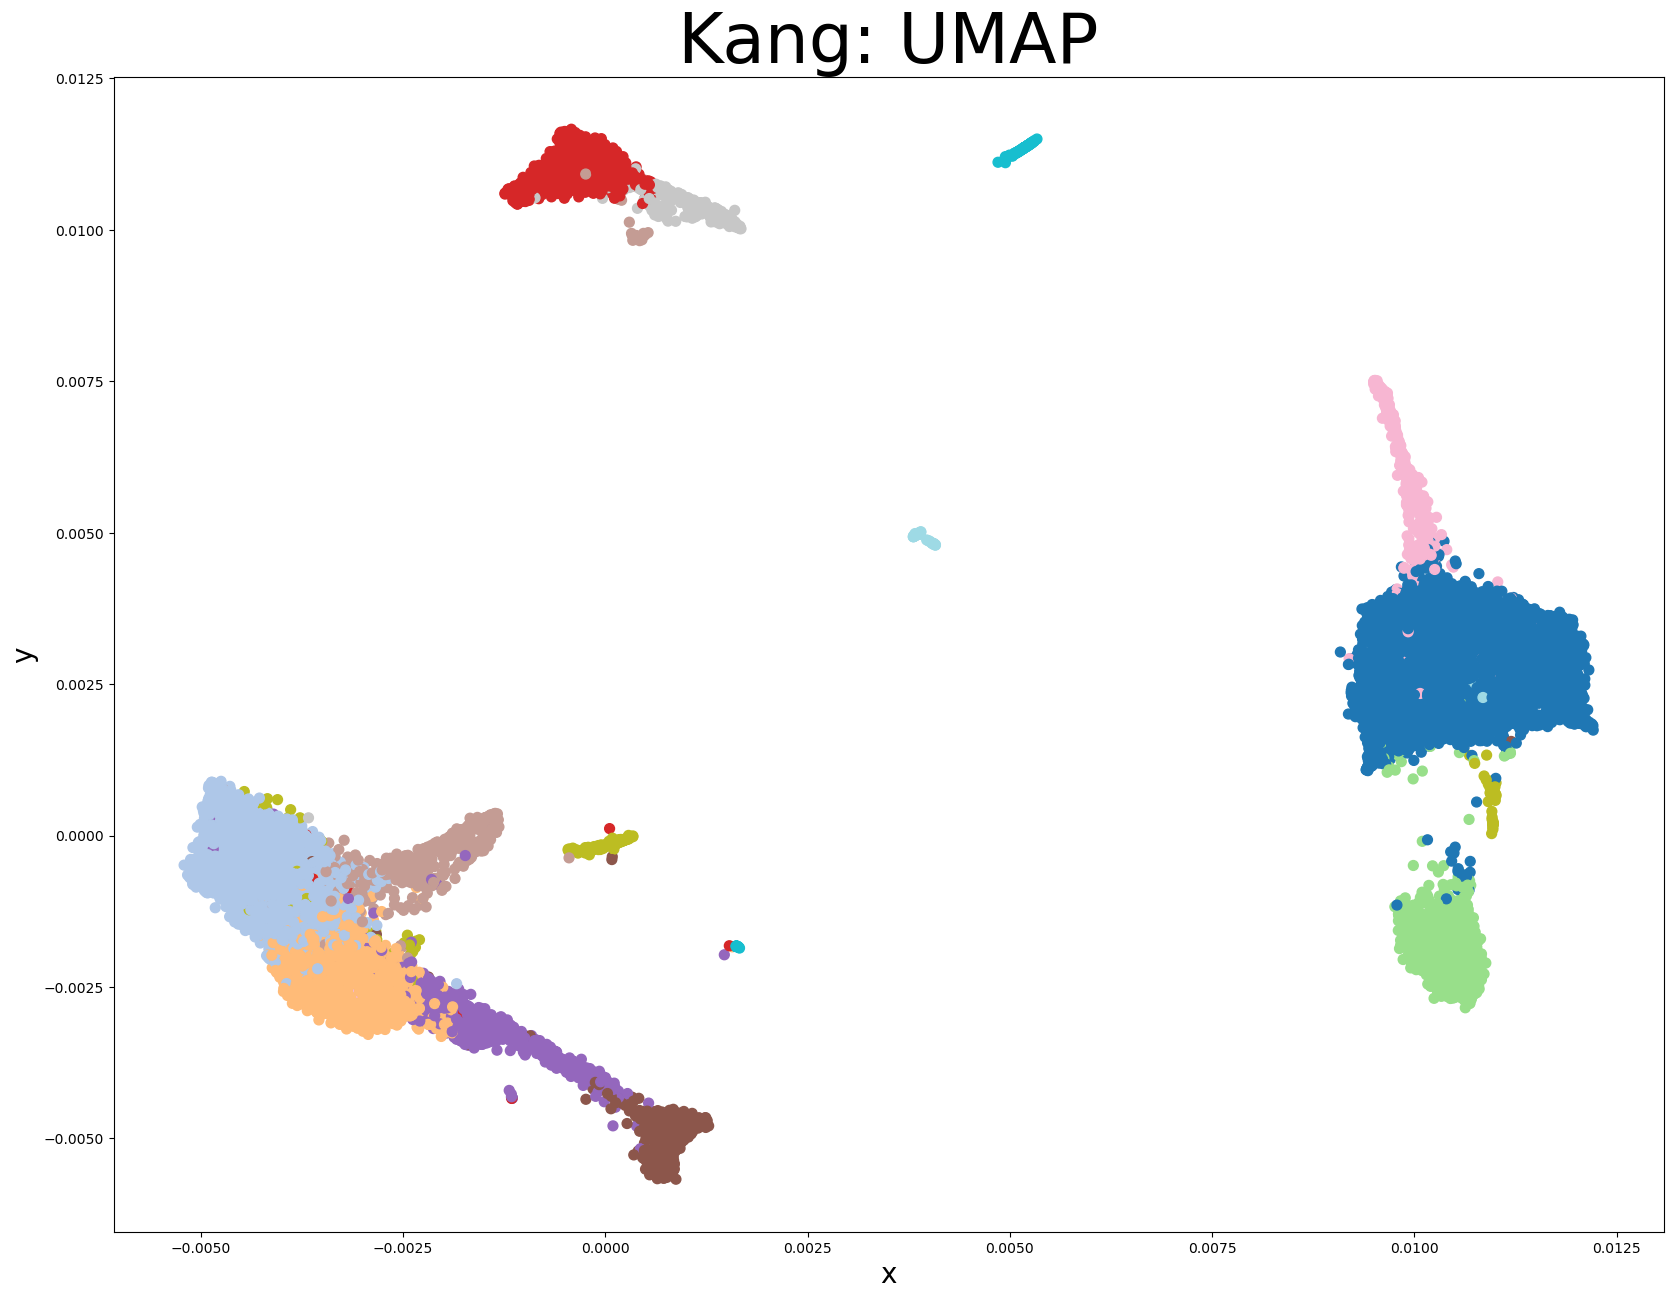

In [9]:
y = embedding
plt.figure(figsize=(20,15))
Turns out this piece of code from the matplotlib examples gave me the answer I was after.

The hex codes of the "tableau" palette are as follows:

tab:red : #d62728
tab:purple : #9467bd
tab:brown : #8c564b
tab:pink : #e377c2
tab:gray : #7f7f7f
tab:olive : #bcbd22
tab:cyan : #17becf

colors = ['#1f77b4','#ff7f0e','#2ca02c']

plt.scatter(y[:,0], y[:,1], s = 50, c=y_train, cmap='tab20') # tab20 for Kang
# tSNE_PCA: \u03B1 = 0.75
plt.title("Kang: UMAP", fontsize = 50)
plt.xlabel("x", fontsize = 20); plt.ylabel("y", fontsize = 20)
plt.show()
